In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline
import os


## Выполнил Широков Александр, ПМ-1701


In [2]:
directory = 'data/*.csv' 
files = glob.glob(directory)[0]
files

'data\\the-total-generation-of-electric.csv'

In [3]:
df = pd.read_csv(files, index_col=0, parse_dates=True)
df = df.fillna(0)
df.head()

,"The total generation of electricity by the U.S. electric industry (monthly data for the period Jan. 1985 ? Oct. 1996) For recent data, click here"
Month,
1985-01-01,227.86
1985-02-01,198.24
1985-03-01,194.97
1985-04-01,184.88
1985-05-01,196.79


In [4]:
df.columns  = ['The total generation of electricity']
df.head(3)

,The total generation of electricity
Month,
1985-01-01,227.86
1985-02-01,198.24
1985-03-01,194.97


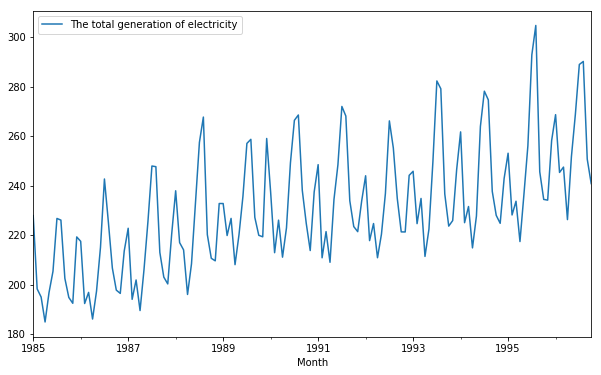

In [8]:
df.plot(figsize=(10, 6))

<div class="alert alert-info">

<h4> Домашнее задание (до 8.03 23:59)</h4>
<p></p>
Выполнять в отдельном файле. В названии файла указать hw3 и свою фамилию.
<p></p>
<ol>
    <li>Для своего временного ряда построить пройденные модели прогнозирования, пользуясь встроенными функциями Statmodels. Сравнить качество моделей (MSE / RMSE).</li>
    <p></p>
    <li>Выбрать лучшую модель и построить прогноз на количество точек, равное периоду сезонности (если имеется, в противном случае - на 12 точек вперед).</li>
    <p></p>
    <li>Отобразить исходный ряд, построенную модель и прогноз на графике. Добавить заголовок, легенду. Прогноз отобразить пунктирной линией.</li>
</ol>
</div>

Давайте вообще вспомним, что мы знаем

- $\alpha$ = `smoothing_level` - параметр сглаживания
- $\beta$ = `smoothing_slope` - параметр направления сглаживания
- $\phi$ = `damping_slope`- коэффициент затухания
- $\gamma$ = `smoothing_seasonal` - параметр сезонности
- $l_0$ = `initial_level` - начальный уровень
- $b_0$ = `initial_slope` - начальный тренд

- Экспоненциальное сглаживание `SimpleExpSmoothing`
    - Мы можем сами поставить начальные значения $\alpha$ = `smoothing_level` и $l_0$ = `initial_level`
    - Мы можем дать модели самой подобрать параметры 
- Метод Хольта
    - Подбор параметров моделью $\alpha$,$\beta$,$l_0$,$b_0$
    - Экспоненциальный тренд модели Хольта `exponential = True` - мультипликативная Хольта 
    - Хольт с затуханием, добавляется переменная затухания $\phi$: `damped = True`
    - Сделаем еще модель экспоненциальную с затуханием
- Метод Хольта-Уинтерса
    - аддитивный метод `trend='add'`
    - мультипликативный метод `trend = 'mul'`
    - аддитивный с затуханием
    - мультипликативный с затуханием


In [56]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [57]:
df.index = pd.DatetimeIndex(df.index.values, freq='MS')
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
y = df.iloc[:,0] 

Так, дадим модели подобрать данные для `SimpleExpSmoothing`. 

Во всех случаях будем прогнозировать на 12 месяцев, так как у нашего ряда сезонность равна этому числу.

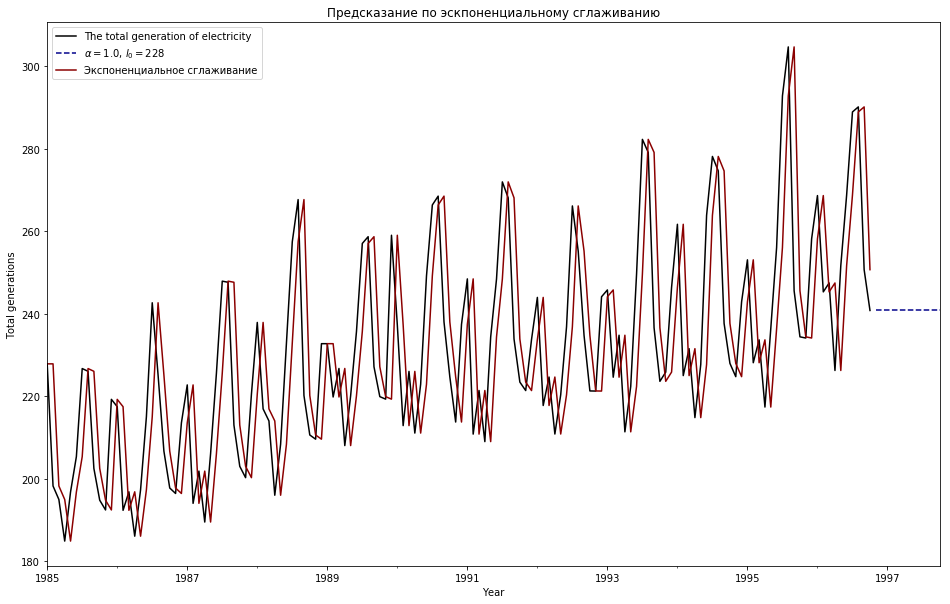

In [157]:
ses = SimpleExpSmoothing(y).fit()
fcast_ses = ses.forecast(12).rename(r'$\alpha=%s$'%ses.model.params['smoothing_level'] + ", " + 
                         r'$l_0=%.f$'%ses.model.params['initial_level'])

ax = y.plot(color='black',legend=True, figsize=(16,10),title = 'Предсказание по эскпоненциальному сглаживанию')
fcast_ses.plot( ax=ax, color='darkblue',style='--' , legend=True)
ses.fittedvalues.plot(ax=ax, legend = True,label ="Экспоненциальное сглаживание" ,color='darkred')
ax.set_ylabel('Total generations')
ax.set_xlabel('Year')
plt.show()

Теперь дадим модели подобрать данные для трех моделей Хольта:

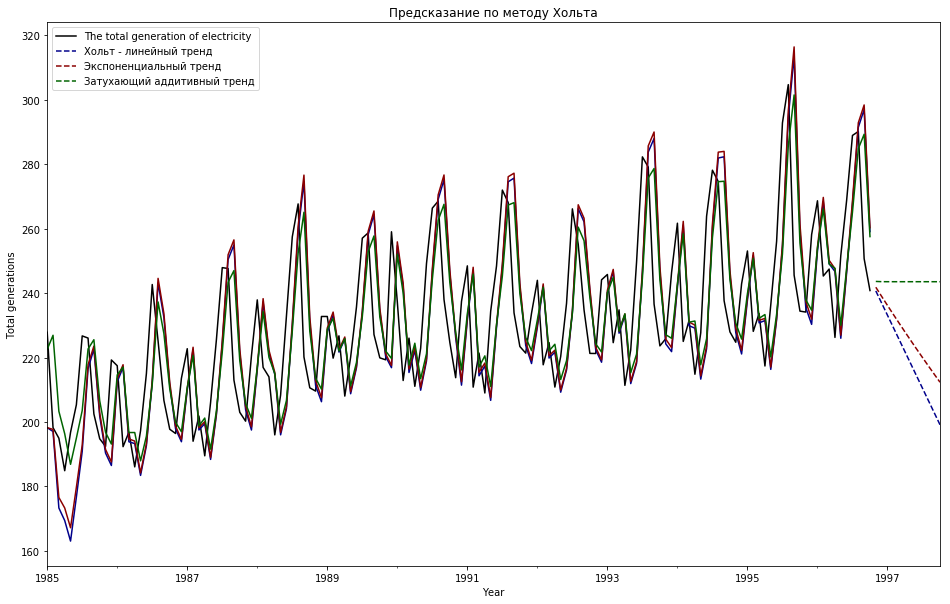

In [158]:
holt_1 = Holt(y).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
f_holt_1 = holt_1 .forecast(12).rename("Хольт - линейный тренд")

holt_2= Holt(y, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
f_holt_2 = holt_2.forecast(12).rename("Экспоненциальный тренд")

holt_3 = Holt(y, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
f_holt_3 = holt_3.forecast(12).rename("Затухающий аддитивный тренд")

ax = y.plot(color="black", figsize=(16,10),title = 'Предсказание по методу Хольта',legend=True)

holt_1 .fittedvalues.plot(ax=ax, color='darkblue')
f_holt_1.plot(ax=ax, color='darkblue', style='--' , legend=True)

holt_2 .fittedvalues.plot(ax=ax, color='darkred')
f_holt_2.plot(ax=ax, color='darkred', style='--' , legend=True)

holt_3.fittedvalues.plot(ax=ax, color='darkgreen')
f_holt_3.plot(ax=ax, color='darkgreen', style='--' , legend=True)
ax.set_ylabel('Total generations')
ax.set_xlabel('Year')
plt.show()

Здорово, конечно, но давайте попытаемся сравнить модели по ошибке SSE и MSE. 

Будем использовать следующие модели:

- Экспоненциальное сглаживание
- Хольт
- Хольт экспоненциальный
- Хольт аддитивный затухающий
- Хольт мультипликативный затухающий

In [159]:
fit1 = SimpleExpSmoothing(y).fit()

fit2 = Holt(y).fit()

fit3 = Holt(y,exponential=True).fit()

fit4 = Holt(y,damped=True).fit(damping_slope=0.09)

fit5 = Holt(y,exponential=True,damped=True).fit()

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Есть встроенная функция, считающая SSE. От нее перейдем к MSE и RMSE

In [160]:
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'initial_level', 'initial_slope']
results = pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE","MSE","RMSE"] ,\
                       columns=['SES', "Holt's","Exponential", "Additive_damped", "Multiplicative_damped"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse] + \
[fit1.sse/len(y)-1] + [np.sqrt(fit1.sse/len(y)-1)]
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse] + \
[fit2.sse/len(y)-1] + [np.sqrt(fit2.sse/len(y)-1)]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse] + \
[fit3.sse/len(y)-1] + [np.sqrt(fit3.sse/len(y)-1)]
results["Additive_damped"] =       [fit4.params[p] for p in params] + [fit4.sse] \
+ [fit4.sse/len(y)-1] + [np.sqrt(fit4.sse/len(y)-1)]
results["Multiplicative_damped"] = [fit5.params[p] for p in params] + [fit5.sse] + \
[fit5.sse/len(y)-1] + [np.sqrt(fit5.sse/len(y)-1)]
results

,SES,Holt's,Exponential,Additive_damped,Multiplicative_damped
$\alpha$,1.000000,1.000000,1.000000,0.999900,1.000000
$\beta$,NaN,0.000000,0.000000,0.999900,1.000000
$\phi$,NaN,NaN,NaN,0.090000,0.115793
$l_0$,227.854905,227.768172,228.586225,227.860000,227.871909
$b_0$,NaN,0.091789,0.996823,0.010000,8.635339
SSE,54404.746626,54403.559057,54327.968618,53773.887228,53700.729191
MSE,382.132018,382.123655,381.591328,377.689347,377.174149
RMSE,19.548197,19.547983,19.534363,19.434231,19.420972


Видим, что пока что **мультипликативная затухающая** модель с подобранными моделью параметрами дает наименьшую ошибку. Визуализируем его

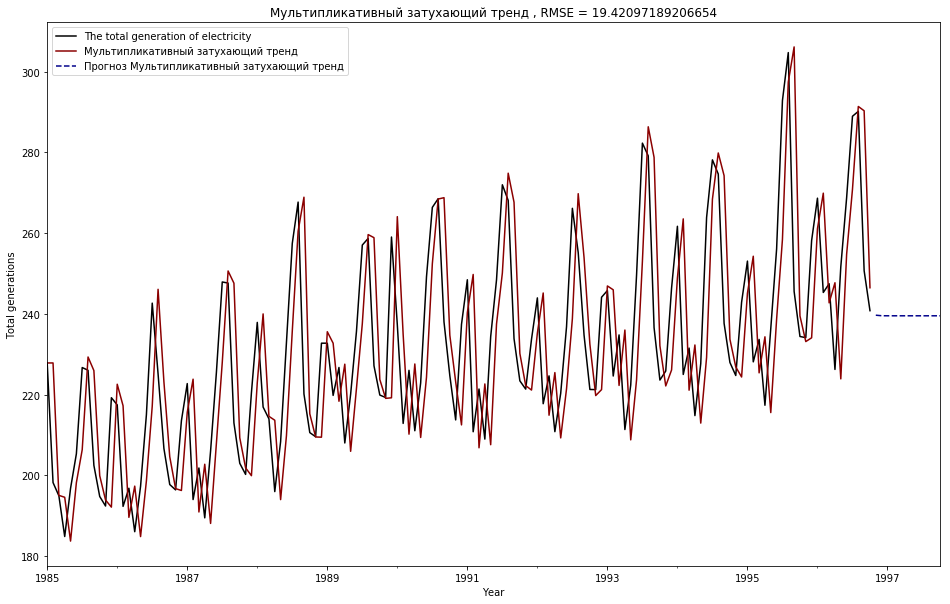

In [161]:
ax = y.plot(color="black", figsize=(16,10),legend=True)

f5 = fit5.forecast(12).rename("Прогноз Мультипликативный затухающий тренд")

fit5.fittedvalues.plot(ax=ax, color='darkred',legend=True,label="Мультипликативный затухающий тренд")
f5.plot(ax=ax, color='darkblue',style='--' ,legend=True)
plt.title('Мультипликативный затухающий тренд' + ' , RMSE = ' + str(results.iloc[:,4].RMSE))
ax.set_ylabel('Total generations')
ax.set_xlabel('Year')
plt.show()

Построим для данных моделей прогноз на 12 дней

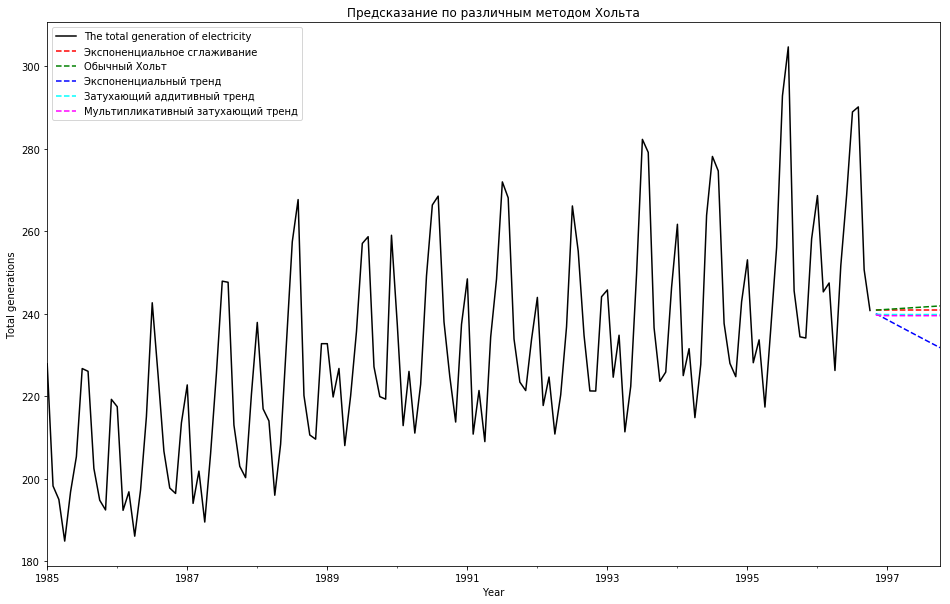

In [162]:
f1 = fit1.forecast(12).rename("Экспоненциальное сглаживание")
f2 = fit2.forecast(12).rename("Обычный Хольт")
f3 = fit3.forecast(12).rename("Экспоненциальный тренд")
f4 = fit4.forecast(12).rename("Затухающий аддитивный тренд")
f5 = fit5.forecast(12).rename("Мультипликативный затухающий тренд")

ax = y.plot(color="black",  figsize=(16,10),legend=True,title="Предсказание по различным методом Хольта")
f1.plot(ax=ax, color='red', style='--',legend=True)
f2.plot(ax=ax, color='green',style='--', legend=True)
f3.plot(ax=ax, color='blue',style='--', legend=True)
f4.plot(ax=ax, color='cyan',style='--', legend=True)
f5.plot(ax=ax, color='magenta',style='--', legend=True)
ax.set_ylabel('Total generations')
ax.set_xlabel('Year')
plt.show()

Построим прогноз для метода Хольта-Уинтерса для различных видов:

In [163]:
fit1 = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE","MSE","RMSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse] + [fit1.sse/len(y)-1] + [np.sqrt(fit1.sse/len(y)-1)]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse] + [fit2.sse/len(y)-1] + [np.sqrt(fit2.sse/len(y)-1)]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse] + [fit3.sse/len(y)-1] + [np.sqrt(fit3.sse/len(y)-1)]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse] + [fit4.sse/len(y)-1] + [np.sqrt(fit4.sse/len(y)-1)]

results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.157895,0.157895,0.157895,0.157895
$\beta$,0.052631,0.052631,0.052631,0.052631
$\phi$,NaN,NaN,0.999899,0.999899
$\gamma$,0.315789,0.315789,0.315789,0.315789
$l_0$,1.017755,1.017755,1.017755,1.017755
$b_0$,0.000007,0.000007,0.000007,0.000007
SSE,6121.322764,6123.187869,6120.501379,6122.365861
MSE,42.107907,42.121041,42.102122,42.115253
RMSE,6.489061,6.490073,6.488615,6.489627


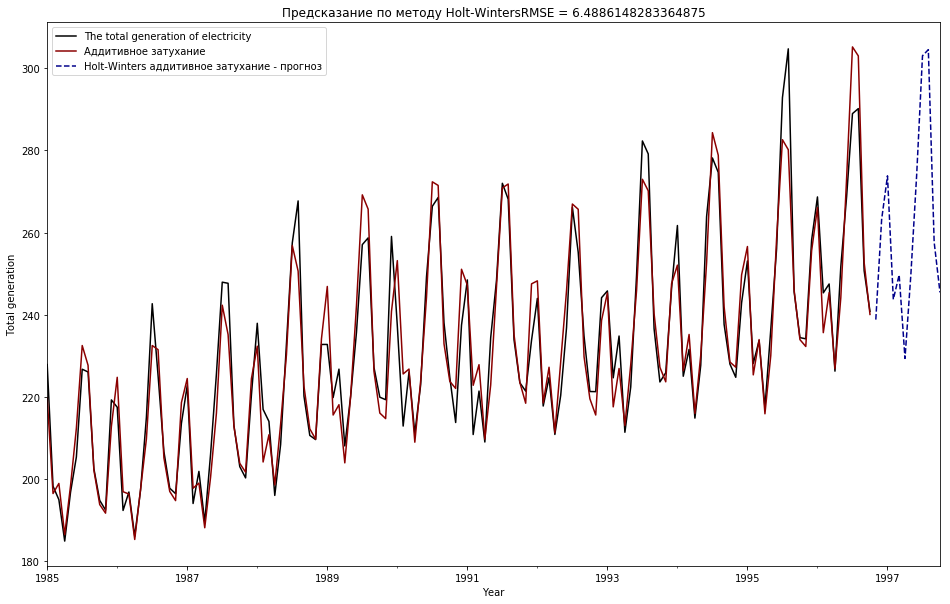

In [164]:
ax = y.plot(figsize=(16,10),color='black', title="Предсказание по методу Holt-Winters" + 'RMSE = ' + str(results.iloc[:,2].RMSE),legend=True )
ax.set_ylabel("Total generation")
ax.set_xlabel("Year")
fit3.fittedvalues.plot(ax=ax, color='darkred',legend = True, label = "Аддитивное затухание")

fit3.forecast(12).rename('Holt-Winters аддитивное затухание - прогноз').plot(ax=ax, style='--', color='darkblue', legend=True)

plt.show()

## Вывод: мы выбирали лучшую модель по RMSE, лучшей оказалась аддитивная модель предсказания Хольта-Уинтерса с затуханием.